# Minimum Vertex Cover Problem
Given an undirected graph $G(V,E)$, find the smallest set of vertices s.t. the set covers the graph (each edge is incident to at least one vertex in the cover set

Solve using DWave's QUBO formulation tools on different hybrid solvers/workflows

In [1]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from dwave.system.samplers import LeapHybridSampler, LeapHybridCQMSampler
from dwave.system.composites import LazyEmbeddingComposite
from pyqubo import Binary
from hybrid import KerberosSampler

## Generate random graph

118


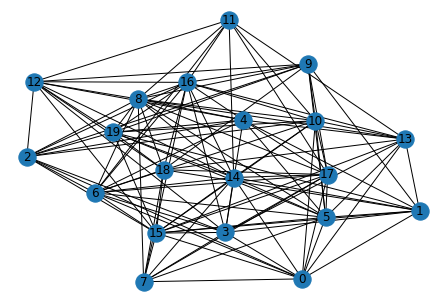

In [2]:
# number of nodes
n = 20
# edge generation probability
p = 0.6
# seed (optional)
seed = 30
# generate graph
graph = nx.gnp_random_graph(n,p,seed)

# draw graph
nx.draw(graph, with_labels=True)

print(len(graph.edges))

## Define hamiltonian and QUBO

For `LeapHybridSampler` and `KerberosSampler`

Objective funtion: min$y=\sum_{i\in V}x_i+P(\sum_{(i,j)}(1-x_i-x_j+x_ix_j)$

In [27]:
# penalty value
P = 8

# define hamiltonian
H = 0
x = []
for i in graph.nodes:
    x.append(Binary(f'x{i}'))
    H += x[i]
    
for (i,j) in graph.edges:
    H += P*(1-x[i]-x[j]+x[i]*x[j])
    
# convert to QUBO (dictionary format) for QPU to use
model = H.compile()
qubo, offset = model.to_qubo()

# get binary quadratic model
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo, offset=offset)

## Solve on LeapHybridSampler

In [28]:
start = time.time()

sampler = LeapHybridSampler()
response1 = sampler.sample(bqm, label='LeapHybridSampler MVC')
solution1 = solution = min(response1.data(["sample", "energy"]), key=lambda s: s.energy)

elapsed = time.time() - start
print("Solved in %.2f seconds" % elapsed)
print(solution1)

Solved in 9.72 seconds
Sample(sample={'x0': 1, 'x1': 1, 'x10': 0, 'x11': 1, 'x12': 1, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 1, 'x9': 1}, energy=10.0)


In [29]:
print(response1)

  x0 x1 x10 x11 x12 x13 x14 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc.
0  1  1   0   1   1   0   1  1  0  0  1  0  1  1  1   10.0       1
['BINARY', 1 rows, 1 samples, 15 variables]


## Recolor graph to show solution

size of cover:  10.0


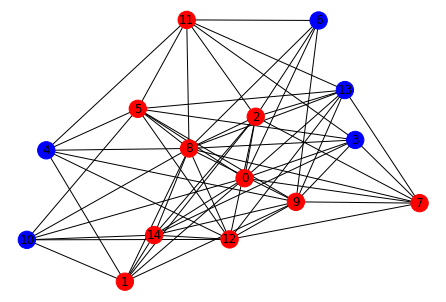

In [16]:
# assign colors
color_map = []
for node in graph:
    if solution1.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('red')
        
nx.draw(graph, node_color=color_map, with_labels=True)

print("size of cover: ", solution1.energy)

## Solve on Kerberos sampler/workflow

In [20]:
start = time.time()

sampler = LeapHybridSampler()
response2 = KerberosSampler().sample(bqm, 
                                     num_reads=3, 
                                     max_iter=10, 
                                     qpu_reads=100, 
                                     tabu_timeout=200,
                                     qpu_params={'label': 'Kerberos MVC'})
solution2 = min(response2.data(["sample", "energy"]), key=lambda s: s.energy)

elapsed = time.time() - start
print("Solved in %.2f seconds" % elapsed)
print(solution2)

Solved in 14.68 seconds
Sample(sample={'x0': 1, 'x1': 1, 'x10': 0, 'x11': 1, 'x12': 1, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 1, 'x9': 1}, energy=10.0)


## Recolor graph to show solution

size of cover:  10.0


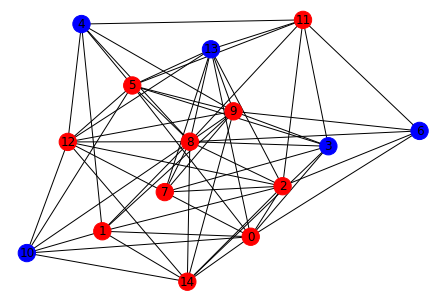

In [19]:
# assign colors
color_map = []
for node in graph:
    if solution2.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('red')
        
nx.draw(graph, node_color=color_map, with_labels=True)

print("size of cover: ", solution2.energy)

## Solve using constrained quadratic model (CQM)
instead of binary quadratic model (more flexibility with constraints)

binary variables for nodes
constraint: $x_i+x_j\geq1$ to ensure cover set

In [3]:
# define cqm model
cqm = dimod.ConstrainedQuadraticModel()

# build CQM variables (binary vars 1 if node n is in cover)
x = [dimod.Binary(f'x{n}') for n in graph.nodes]

# set objective
cqm.set_objective(sum(x))

# add constraint
for (i,j) in graph.edges:
    cqm.add_constraint(x[i]+x[j]>=1)

In [4]:
# run hybrid solver
sampler = LeapHybridCQMSampler()
sampleset = sampler.sample_cqm(cqm, label='CQM MVC')
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)

try:
    sample = feasible_sampleset.first.sample
    solution3 = feasible_sampleset.first
    print(solution3)
except:
    print("\nNo feasible solutions found")

Sample(sample={'x0': 1.0, 'x1': 1.0, 'x10': 1.0, 'x11': 1.0, 'x12': 1.0, 'x13': 0.0, 'x14': 1.0, 'x15': 1.0, 'x16': 1.0, 'x17': 1.0, 'x18': 1.0, 'x19': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0, 'x8': 1.0, 'x9': 0.0}, energy=16.0, num_occurrences=1, is_feasible=True, is_satisfied=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True

In [5]:
print(solution3.energy)

16.0


## Recolor graph to show solution

size of cover:  16.0


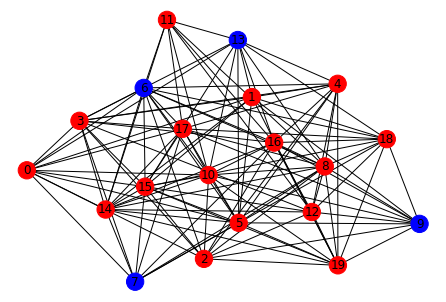

In [6]:
# assign colors
color_map = []
for node in graph:
    if solution3.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('red')
        
nx.draw(graph, node_color=color_map, with_labels=True)

print("size of cover: ", solution3.energy)